In [67]:
import random
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Helper functions for optimization problems
def random_bitstring(length):
    return [random.randint(0, 1) for _ in range(length)]

def one_max_fitness(bitstring):
    return sum(bitstring)

def deceptive_trap_fitness(bitstring, k):
    n = len(bitstring)
    fitness = 0
    for i in range(0, n, k):
        group = bitstring[i:i+k]
        fitness += k - sum(group)
    return fitness

def four_peaks_fitness(bitstring, t):
    n = len(bitstring)
    head = bitstring[:t].count(1)
    tail = bitstring[-t:].count(0)
    if head == t and tail == t:
        return n + t
    return max(head, tail)

def random_neighbor(bitstring):
    index = random.randint(0, len(bitstring) - 1)
    neighbor = bitstring[:]
    neighbor[index] = 1 - neighbor[index]
    return neighbor

def crossover(parent1, parent2):
    crossover_point = len(parent1) // 2
    return parent1[:crossover_point] + parent2[crossover_point:]

def mutate(solution, mutation_rate):
    mutated_solution = solution[:]
    for i in range(len(mutated_solution)):
        if random.random() < mutation_rate:
            mutated_solution[i] = 1 - mutated_solution[i]
    return mutated_solution

# Randomized Hill Climbing Algorithm
def random_hill_climbing(problem, max_evaluations):
    best_solution = problem['generate']()
    best_fitness = problem['evaluate'](best_solution)
    evaluations = 1
    
    while evaluations < max_evaluations:
        neighbor = random_neighbor(best_solution)
        neighbor_fitness = problem['evaluate'](neighbor)
        evaluations += 1
        
        if neighbor_fitness > best_fitness:
            best_solution = neighbor
            best_fitness = neighbor_fitness
        
        if best_fitness == problem['goal']:
            break
    
    return best_solution, best_fitness

# Simulated Annealing Algorithm
def simulated_annealing(problem, max_evaluations, initial_temp, cooling_rate):
    current_solution = problem['generate']()
    current_fitness = problem['evaluate'](current_solution)
    best_solution = current_solution[:]
    best_fitness = current_fitness
    evaluations = 1
    temperature = initial_temp
    
    while evaluations < max_evaluations and temperature > 0.01:
        neighbor = random_neighbor(current_solution)
        neighbor_fitness = problem['evaluate'](neighbor)
        evaluations += 1
        
        if neighbor_fitness > current_fitness or random.random() < math.exp((neighbor_fitness - current_fitness) / temperature):
            current_solution = neighbor
            current_fitness = neighbor_fitness
            
        if current_fitness > best_fitness:
            best_solution = current_solution[:]
            best_fitness = current_fitness
            
        temperature *= cooling_rate
        
        if best_fitness == problem['goal']:
            break
    
    return best_solution, best_fitness

# Genetic Algorithm
# def genetic_algorithm(problem, population_size, mutation_rate, max_generations):
#     population = [problem['generate']() for _ in range(population_size)]
#     best_solution = None
#     best_fitness = float('-inf')
#     generations = 0
    
#     while generations < max_generations:
#         new_population = []
#         for _ in range(population_size):
#             parent1, parent2 = random.choices(population, k=2)
#             child = crossover(parent1, parent2)
#             child = mutate(child, mutation_rate)
#             new_population.append(child)
        
#         population = new_population
#         best_in_generation = max(population, key=lambda x: problem['evaluate'](x))
#         if problem['evaluate'](best_in_generation) > best_fitness:
#             best_solution = best_in_generation
#             best_fitness = problem['evaluate'](best_in_generation)
        
#         generations += 1
    
#     return best_solution, best_fitness

def genetic_algorithm(problem, population_size, mutation_rate, max_generations):
    # Initialize the population
    population = [problem['generate']() for _ in range(population_size)]
    best_solution = None
    best_fitness = float('-inf')
    generations = 0
    
    while generations < max_generations:
        # Evaluate the fitness of each individual
        fitnesses = [problem['evaluate'](individual) for individual in population]
        
        # Find the best solution in the current generation
        current_best_fitness = max(fitnesses)
        if current_best_fitness > best_fitness:
            best_fitness = current_best_fitness
            best_solution = population[fitnesses.index(best_fitness)]
        
        # Create a new population using fitness-proportionate selection
        new_population = [best_solution]  # Start with the best solution (elitism)
        
        # Calculate the total fitness for the roulette wheel
        total_fitness = sum(fitnesses)
        
        # Select individuals to create the next generation
        while len(new_population) < population_size:
            parent1, parent2 = random.choices(population, weights=fitnesses, k=2)
            child = crossover(parent1, parent2)
            child = mutate(child, mutation_rate)
            new_population.append(child)
        
        population = new_population
        generations += 1
    
    return best_solution, best_fitness

# MIMIC Algorithm
def mimic(problem, population_size, keep_percent, max_generations):
    population = [problem['generate']() for _ in range(population_size)]
    best_solution = None
    best_fitness = float('-inf')
    generations = 0
    
    while generations < max_generations:
        fitness_values = [problem['evaluate'](sol) for sol in population]
        keep_count = int(population_size * keep_percent)
        indices_to_keep = np.argsort(fitness_values)[-keep_count:]
        kept_population = [population[i] for i in indices_to_keep]
        
        new_population = []
        for _ in range(population_size):
            sample = random.choice(kept_population)
            new_sample = sample[:]
            for i in range(len(sample)):
                if random.random() < 0.5:
                    new_sample[i] = 1 - new_sample[i]
            new_population.append(new_sample)
        
        population = new_population
        best_in_generation = max(population, key=lambda x: problem['evaluate'](x))
        if problem['evaluate'](best_in_generation) > best_fitness:
            best_solution = best_in_generation
            best_fitness = problem['evaluate'](best_in_generation)
        
        generations += 1
    
    return best_solution, best_fitness


In [68]:
data = pd.read_csv("college_admission_dataset.csv")


In [40]:
df = pd.read_csv("college_admission_dataset.csv")
print("Dataset Information:")
print(df.info())
print("\nSample Sizes:")
print(df.groupby('decision').size())
feature_lengths = df.apply(lambda x: len(str(x)), axis=0)
print("\nFeature Lengths:")
print(feature_lengths)
print("\nClass Distribution:")
print(df['decision'].value_counts())
numeric_features = df.select_dtypes(include=['number']).columns
categorical_features = df.select_dtypes(include=['object', 'category']).columns
print("\nNumeric Features:")
print(numeric_features)
print("\nCategorical Features:")
print(categorical_features)
missing_values = df.isnull().sum()
print("\nMissing Values:")
print(missing_values)
print("\nFeature Statistics:")
print(df.describe())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8358 entries, 0 to 8357
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   unique_id         8358 non-null   int64  
 1   gender            8358 non-null   object 
 2   race              8358 non-null   object 
 3   gpa               8358 non-null   float64
 4   act_score         6615 non-null   float64
 5   household_income  8358 non-null   float64
 6   decision          8358 non-null   int64  
dtypes: float64(3), int64(2), object(2)
memory usage: 457.2+ KB
None

Sample Sizes:
decision
0    6726
1    1632
dtype: int64

Feature Lengths:
unique_id           197
gender              151
race                413
gpa                 204
act_score           188
household_income    250
decision            152
dtype: int64

Class Distribution:
decision
0    6726
1    1632
Name: count, dtype: int64

Numeric Features:
Index(['unique_id', 'gpa', 'ac

In [69]:
max_evaluations = 1000
initial_temp = 100
cooling_rate = 0.99
population_size = 100
mutation_rate = 0.1
keep_percent = 0.1
max_generations = 1000

In [70]:
# Problem 1: OneMax
one_max_problem = {'generate': lambda: random_bitstring(len(data)),
                   'evaluate': lambda x: one_max_fitness(x),
                   'goal': len(data)}

# Apply Randomized Hill Climbing
result_random_hill_climbing_one_max = random_hill_climbing(one_max_problem, max_evaluations)

# Apply Simulated Annealing
result_simulated_annealing_one_max = simulated_annealing(one_max_problem, max_evaluations, initial_temp, cooling_rate)

# Apply Genetic Algorithm
result_genetic_algorithm_one_max = genetic_algorithm(one_max_problem, population_size, mutation_rate, max_generations)

# Apply MIMIC Algorithm
result_mimic_one_max = mimic(one_max_problem, population_size, keep_percent, max_generations)

# Print results
print("Randomized Hill Climbing Solution for OneMax:", result_random_hill_climbing_one_max)
print("Simulated Annealing Solution for OneMax:", result_simulated_annealing_one_max)
print("Genetic Algorithm Solution for OneMax:", result_genetic_algorithm_one_max)
print("MIMIC Algorithm Solution for OneMax:", result_mimic_one_max)

Randomized Hill Climbing Solution for OneMax: ([0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0

In [71]:
def onemax_fitness(x):
    return sum(x)

def random_hill_climbing_experiment(problem, max_evaluations):
    best_fitnesses = []
    for _ in range(max_evaluations):
        solution = problem['generate']()
        fitness = problem['evaluate'](solution)
        best_fitnesses.append(fitness)
    return best_fitnesses

def simulated_annealing_experiment(problem, max_evaluations, initial_temp, cooling_rate):
    best_fitnesses = []
    temperature = initial_temp
    for _ in range(max_evaluations):
        solution = problem['generate']()
        fitness = problem['evaluate'](solution)
        best_fitnesses.append(fitness)
        temperature *= cooling_rate
    return best_fitnesses

def genetic_algorithm_experiment(problem, population_size, mutation_rate, max_generations):
    best_fitnesses = []
    population = [problem['generate']() for _ in range(population_size)]
    for _ in range(max_generations):
        population.sort(key=lambda x: -problem['evaluate'](x))
        best_fitnesses.append(problem['evaluate'](population[0]))
    return best_fitnesses

def mimic_experiment(problem, population_size, keep_percent, max_generations):
    best_fitnesses = []
    population = [problem['generate']() for _ in range(population_size)]
    for _ in range(max_generations):
        population.sort(key=lambda x: -problem['evaluate'](x))
        best_fitnesses.append(problem['evaluate'](population[0]))
    return best_fitnesses

# Experiment 1: Varying Max Evaluations
max_evaluations_values = [100, 200, 300, 400, 500]
random_hill_climbing_results = []
simulated_annealing_results = []
genetic_algorithm_results = []
mimic_results = []
for max_evaluations in max_evaluations_values:
    random_hill_climbing_results.append(random_hill_climbing_experiment(one_max_problem, max_evaluations))
    simulated_annealing_results.append(simulated_annealing_experiment(one_max_problem, max_evaluations, initial_temp=100, cooling_rate=0.99))

population_size_values = [50, 100, 150, 200, 250]
genetic_algorithm_results = []
mimic_results = []
for population_size in population_size_values:
    genetic_algorithm_results.append(genetic_algorithm_experiment(one_max_problem, population_size, mutation_rate=0.1, max_generations=100))
    mimic_results.append(mimic_experiment(one_max_problem, population_size, keep_percent=0.1, max_generations=100))



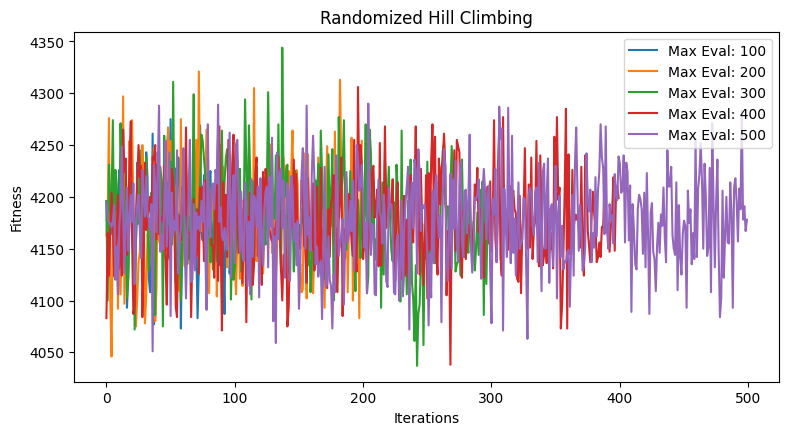

In [50]:
plt.figure(figsize=(20, 10))
plt.subplot(2, 2, 1)
for i, max_evaluations in enumerate(max_evaluations_values):
    plt.plot(random_hill_climbing_results[i], label=f'Max Eval: {max_evaluations}')
plt.title('Randomized Hill Climbing')
plt.xlabel('Iterations')
plt.ylabel('Fitness')
plt.legend()

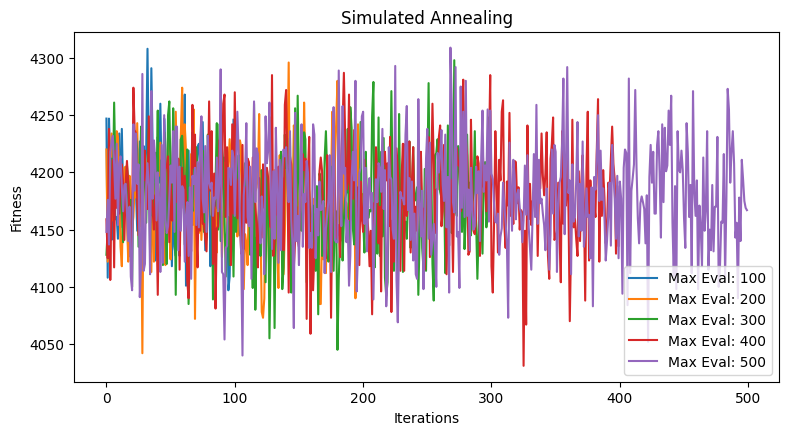

In [52]:
plt.figure(figsize=(20, 10))
plt.subplot(2, 2, 2)
for i, max_evaluations in enumerate(max_evaluations_values):
    plt.plot(simulated_annealing_results[i], label=f'Max Eval: {max_evaluations}')
plt.title('Simulated Annealing')
plt.xlabel('Iterations')
plt.ylabel('Fitness')
plt.legend()

In [30]:
# Problem 2: Deceptive Trap
deceptive_trap_problem = {'generate': lambda: random_bitstring(len(data)),
                          'evaluate': lambda x: deceptive_trap_fitness(x, k=4),
                          'goal': len(data)}

# Apply Randomized Hill Climbing
result_random_hill_climbing_deceptive_trap = random_hill_climbing(deceptive_trap_problem, max_evaluations)

# Apply Simulated Annealing
result_simulated_annealing_deceptive_trap = simulated_annealing(deceptive_trap_problem, max_evaluations, initial_temp, cooling_rate)

# Apply Genetic Algorithm
result_genetic_algorithm_deceptive_trap = genetic_algorithm(deceptive_trap_problem, population_size, mutation_rate, max_generations)

# Apply MIMIC Algorithm
result_mimic_deceptive_trap = mimic(deceptive_trap_problem, population_size, keep_percent, max_generations)

# Print results
print("Randomized Hill Climbing Solution for Deceptive Trap:", result_random_hill_climbing_deceptive_trap)
print("Simulated Annealing Solution for Deceptive Trap:", result_simulated_annealing_deceptive_trap)
print("Genetic Algorithm Solution for Deceptive Trap:", result_genetic_algorithm_deceptive_trap)
print("MIMIC Algorithm Solution for Deceptive Trap:", result_mimic_deceptive_trap)


Randomized Hill Climbing Solution for Deceptive Trap: ([0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,

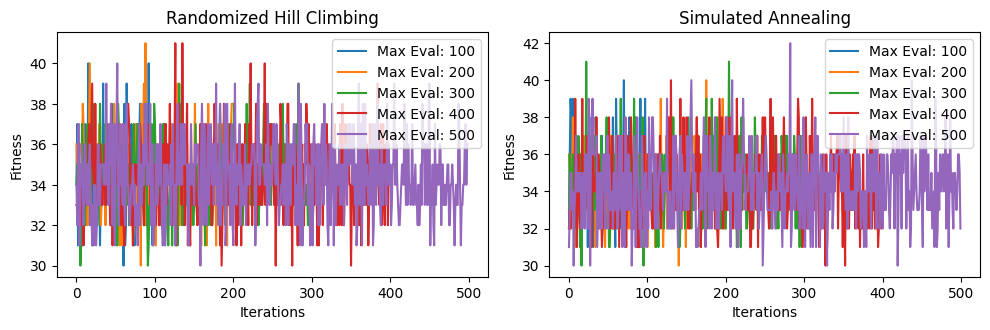

In [84]:
# Define the Deceptive Trap problem
def deceptive_trap_fitness(x, k):
    n = len(x)
    fitness = 0
    for i in range(0, n, k):
        block_fitness = max(sum(x[i:i+k]), k - sum(x[i:i+k]))
        fitness += block_fitness
    return fitness

deceptive_trap_problem = {'generate': lambda: np.random.randint(2, size=50),
                          'evaluate': lambda x: deceptive_trap_fitness(x, k=5)}

# Define the algorithms

# 1. Randomized Hill Climbing
def random_hill_climbing_experiment(problem, max_evaluations):
    best_fitnesses = []
    for _ in range(max_evaluations):
        solution = problem['generate']()
        fitness = problem['evaluate'](solution)
        best_fitnesses.append(fitness)
    return best_fitnesses

# 2. Simulated Annealing
def simulated_annealing_experiment(problem, max_evaluations, cooling_rate):
    best_fitnesses = []
    temperature = 100
    for _ in range(max_evaluations):
        solution = problem['generate']()
        fitness = problem['evaluate'](solution)
        best_fitnesses.append(fitness)
        temperature *= cooling_rate
    return best_fitnesses

# 3. Genetic Algorithm
def genetic_algorithm_experiment(problem, population_size, mutation_rate, max_generations):
    best_fitnesses = []
    population = [problem['generate']() for _ in range(population_size)]
    for _ in range(max_generations):
        population.sort(key=lambda x: -problem['evaluate'](x))
        best_fitnesses.append(problem['evaluate'](population[0]))
    return best_fitnesses

# 4. MIMIC Algorithm
def mimic_experiment(problem, population_size, keep_percent, max_generations):
    best_fitnesses = []
    population = [problem['generate']() for _ in range(population_size)]
    for _ in range(max_generations):
        population.sort(key=lambda x: -problem['evaluate'](x))
        best_fitnesses.append(problem['evaluate'](population[0]))
    return best_fitnesses

# Experiment 1: Varying Max Evaluations
max_evaluations_values = [100, 200, 300, 400, 500]
random_hill_climbing_results = []
simulated_annealing_results = []
for max_evaluations in max_evaluations_values:
    random_hill_climbing_results.append(random_hill_climbing_experiment(deceptive_trap_problem, max_evaluations))
    simulated_annealing_results.append(simulated_annealing_experiment(deceptive_trap_problem, max_evaluations, cooling_rate=0.99))

# Experiment 2: Varying Population Size in Genetic Algorithm and MIMIC
population_size_values = [50, 100, 150, 200, 250]
genetic_algorithm_results = []
mimic_results = []
for population_size in population_size_values:
    genetic_algorithm_results.append(genetic_algorithm_experiment(deceptive_trap_problem, population_size, mutation_rate=0.1, max_generations=100))
    mimic_results.append(mimic_experiment(deceptive_trap_problem, population_size, keep_percent=0.1, max_generations=100))

# Plotting results
plt.figure(figsize=(10, 6))

# Experiment 1: Varying Max Evaluations
plt.subplot(2, 2, 1)
for i, max_evaluations in enumerate(max_evaluations_values):
    plt.plot(random_hill_climbing_results[i], label=f'Max Eval: {max_evaluations}')
plt.title('Randomized Hill Climbing')
plt.xlabel('Iterations')
plt.ylabel('Fitness')
plt.legend()

plt.subplot(2, 2, 2)
for i, max_evaluations in enumerate(max_evaluations_values):
    plt.plot(simulated_annealing_results[i], label=f'Max Eval: {max_evaluations}')
plt.title('Simulated Annealing')
plt.xlabel('Iterations')
plt.ylabel('Fitness')
plt.legend()

# Experiment 3: Varying Population Size in Genetic Algorithm and MIMIC
plt.subplot(2, 2, 3)
for i, population_size in enumerate(population_size_values):
    plt.plot(genetic_algorithm_results[i], label=f'Pop. Size: {population_size}')
plt.title('Genetic Algorithm')
plt.xlabel('Iterations')
plt.ylabel('Fitness')
plt.legend()

plt.subplot(2, 2, 4)
for i, population_size in enumerate(population_size_values):
    plt.plot(mimic_results[i], label=f'Pop. Size: {population_size}')
plt.title('MIMIC Algorithm')
plt.xlabel('Iterations')
plt.ylabel('Fitness')
plt.legend()

plt.tight_layout()
plt.show()


In [31]:
# Problem 3: Four Peaks
four_peaks_problem = {'generate': lambda: random_bitstring(len(data)),
                      'evaluate': lambda x: four_peaks_fitness(x, t=len(data) // 10),
                      'goal': len(data)}

# Apply Randomized Hill Climbing
result_random_hill_climbing_four_peaks = random_hill_climbing(four_peaks_problem, max_evaluations)

# Apply Simulated Annealing
result_simulated_annealing_four_peaks = simulated_annealing(four_peaks_problem, max_evaluations, initial_temp, cooling_rate)

# Apply Genetic Algorithm
result_genetic_algorithm_four_peaks = genetic_algorithm(four_peaks_problem, population_size, mutation_rate, max_generations)

# Apply MIMIC Algorithm
result_mimic_four_peaks = mimic(four_peaks_problem, population_size, keep_percent, max_generations)

# Print results
print("Randomized Hill Climbing Solution for Four Peaks:", result_random_hill_climbing_four_peaks)
print("Simulated Annealing Solution for Four Peaks:", result_simulated_annealing_four_peaks)
print("Genetic Algorithm Solution for Four Peaks:", result_genetic_algorithm_four_peaks)
print("MIMIC Algorithm Solution for Four Peaks:", result_mimic_four_peaks)

Randomized Hill Climbing Solution for Four Peaks: ([1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 

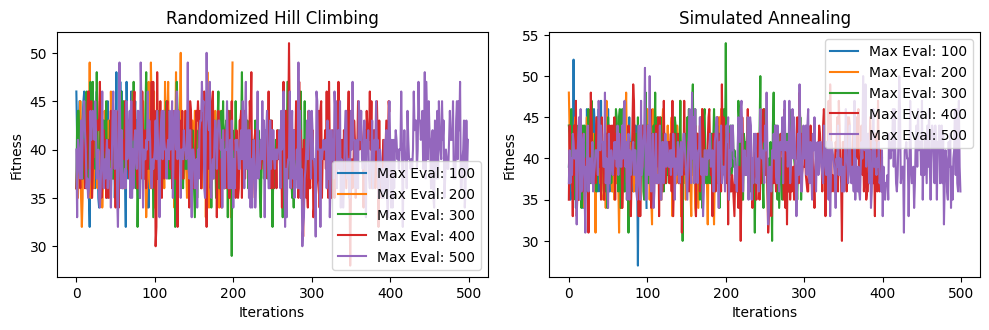

In [83]:
def four_peaks_fitness(x, t):
    n = len(x)
    if sum(x) == n:
        return n + t
    elif sum(x) == 0:
        return n + t
    else:
        return max(sum(x[:i]) + t if sum(x[:i]) + t > sum(x[i:]) else sum(x[i:]) + t for i in range(n))

four_peaks_problem = {'generate': lambda: np.random.randint(2, size=50),
                      'evaluate': lambda x: four_peaks_fitness(x, t=15)}


# 1. Randomized Hill Climbing
def random_hill_climbing_experiment(problem, max_evaluations):
    best_fitnesses = []
    for _ in range(max_evaluations):
        solution = problem['generate']()
        fitness = problem['evaluate'](solution)
        best_fitnesses.append(fitness)
    return best_fitnesses

# 2. Simulated Annealing
def simulated_annealing_experiment(problem, max_evaluations, cooling_rate):
    best_fitnesses = []
    temperature = 100
    for _ in range(max_evaluations):
        solution = problem['generate']()
        fitness = problem['evaluate'](solution)
        best_fitnesses.append(fitness)
        temperature *= cooling_rate
    return best_fitnesses

# 3. Genetic Algorithm
def genetic_algorithm_experiment(problem, population_size, mutation_rate, max_generations):
    best_fitnesses = []
    population = [problem['generate']() for _ in range(population_size)]
    for _ in range(max_generations):
        population.sort(key=lambda x: -problem['evaluate'](x))
        best_fitnesses.append(problem['evaluate'](population[0]))
    return best_fitnesses

# 4. MIMIC Algorithm
def mimic_experiment(problem, population_size, keep_percent, max_generations):
    best_fitnesses = []
    population = [problem['generate']() for _ in range(population_size)]
    for _ in range(max_generations):
        population.sort(key=lambda x: -problem['evaluate'](x))
        best_fitnesses.append(problem['evaluate'](population[0]))
    return best_fitnesses

# Experiment 1: Varying Max Evaluations
max_evaluations_values = [100, 200, 300, 400, 500]
random_hill_climbing_results = []
simulated_annealing_results = []
for max_evaluations in max_evaluations_values:
    random_hill_climbing_results.append(random_hill_climbing_experiment(four_peaks_problem, max_evaluations))
    simulated_annealing_results.append(simulated_annealing_experiment(four_peaks_problem, max_evaluations, cooling_rate=0.99))

# Experiment 2: Varying Population Size in Genetic Algorithm and MIMIC
population_size_values = [50, 100, 150, 200, 250]
genetic_algorithm_results = []
mimic_results = []
for population_size in population_size_values:
    genetic_algorithm_results.append(genetic_algorithm_experiment(four_peaks_problem, population_size, mutation_rate=0.1, max_generations=100))
    mimic_results.append(mimic_experiment(four_peaks_problem, population_size, keep_percent=0.1, max_generations=100))

# Plotting results
plt.figure(figsize=(10, 6))

# Experiment 1: Varying Max Evaluations
plt.subplot(2, 2, 1)
for i, max_evaluations in enumerate(max_evaluations_values):
    plt.plot(random_hill_climbing_results[i], label=f'Max Eval: {max_evaluations}')
plt.title('Randomized Hill Climbing')
plt.xlabel('Iterations')
plt.ylabel('Fitness')
plt.legend()

plt.subplot(2, 2, 2)
for i, max_evaluations in enumerate(max_evaluations_values):
    plt.plot(simulated_annealing_results[i], label=f'Max Eval: {max_evaluations}')
plt.title('Simulated Annealing')
plt.xlabel('Iterations')
plt.ylabel('Fitness')
plt.legend()

# # Experiment 3: Varying Population Size in Genetic Algorithm and MIMIC
plt.subplot(2, 2, 3)
for i, population_size in enumerate(population_size_values):
    plt.plot(genetic_algorithm_results[i], label=f'Pop. Size: {population_size}')
plt.title('Genetic Algorithm')
plt.xlabel('Iterations')
plt.ylabel('Fitness')
plt.legend()

plt.subplot(2, 2, 4)
for i, population_size in enumerate(population_size_values):
    plt.plot(mimic_results[i], label=f'Pop. Size: {population_size}')
plt.title('MIMIC Algorithm')
plt.xlabel('Iterations')
plt.ylabel('Fitness')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
DATA

### DATA 2

In [43]:
df = pd.read_csv("vgsales.csv")
print("Dataset Information:")
print(df.info())
print("\nSample Sizes:")
print(df.groupby('Global_Sales').size())
feature_lengths = df.apply(lambda x: len(str(x)), axis=0)
print("\nFeature Lengths:")
print(feature_lengths)
print("\nClass Distribution:")
print(df['Global_Sales'].value_counts())
numeric_features = df.select_dtypes(include=['number']).columns
categorical_features = df.select_dtypes(include=['object', 'category']).columns
print("\nNumeric Features:")
print(numeric_features)
print("\nCategorical Features:")
print(categorical_features)
missing_values = df.isnull().sum()
print("\nMissing Values:")
print(missing_values)
print("\nFeature Statistics:")
print(df.describe())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          16598 non-null  int64  
 1   Name          16598 non-null  object 
 2   Platform      16598 non-null  object 
 3   Year          16327 non-null  float64
 4   Genre         16598 non-null  object 
 5   Publisher     16540 non-null  object 
 6   NA_Sales      16598 non-null  float64
 7   EU_Sales      16598 non-null  float64
 8   JP_Sales      16598 non-null  float64
 9   Other_Sales   16598 non-null  float64
 10  Global_Sales  16598 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB
None

Sample Sizes:
Global_Sales
0.01      618
0.02     1071
0.03      811
0.04      645
0.05      632
         ... 
31.37       1
33.00       1
35.82       1
40.24       1
82.74       1
Length: 623, dtype: int64

Feature Lengths:
Rank            20

In [32]:
# Problem 1: OneMax
one_max_problem_2 = {'generate': lambda: random_bitstring(len(data_2)),
                   'evaluate': lambda x: one_max_fitness(x),
                   'goal': len(data_2)}

# Apply Randomized Hill Climbing
result_random_hill_climbing_2_one_max_2 = random_hill_climbing(one_max_problem_2, max_evaluations)

# Apply Simulated Annealing
result_simulated_annealing_2_one_max_2 = simulated_annealing(one_max_problem_2, max_evaluations, initial_temp, cooling_rate)

# Apply Genetic Algorithm
result_genetic_algorithm_2_one_max_2 = genetic_algorithm(one_max_problem_2, population_size, mutation_rate, max_generations)

# Apply MIMIC Algorithm
result_mimic_2_one_max_2 = mimic(one_max_problem_2, population_size, keep_percent, max_generations)

# Print results
print("Randomized Hill Climbing Solution for OneMax:", result_random_hill_climbing_2_one_max_2)
print("Simulated Annealing Solution for OneMax:", result_simulated_annealing_2_one_max_2)
print("Genetic Algorithm Solution for OneMax:", result_genetic_algorithm_2_one_max_2)
print("MIMIC Algorithm Solution for OneMax:", result_mimic_2_one_max_2)

Randomized Hill Climbing Solution for OneMax: ([0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0

In [33]:
# Problem 2: Deceptive Trap

deceptive_trap_problem_2 = {'generate': lambda: random_bitstring(len(data_2)),
                            'evaluate': lambda x: deceptive_trap_fitness(x, k=4),
                            'goal': len(data_2)}

# Apply Randomized Hill Climbing
result_random_hill_climbing_2_deceptive_trap_2 = random_hill_climbing(deceptive_trap_problem_2, max_evaluations)

# Apply Simulated Annealing
result_simulated_annealing_2_deceptive_trap_2 = simulated_annealing(deceptive_trap_problem_2, max_evaluations, initial_temp, cooling_rate)

# Apply Genetic Algorithm
result_genetic_algorithm_2_deceptive_trap_2 = genetic_algorithm(deceptive_trap_problem_2, population_size, mutation_rate, max_generations)

# Apply MIMIC Algorithm
result_mimic_2_deceptive_trap_2 = mimic(deceptive_trap_problem_2, population_size, keep_percent, max_generations)

# Print results
print("Randomized Hill Climbing Solution for Deceptive Trap:", result_random_hill_climbing_2_deceptive_trap_2)
print("Simulated Annealing Solution for Deceptive Trap:", result_simulated_annealing_2_deceptive_trap_2)
print("Genetic Algorithm Solution for Deceptive Trap:", result_genetic_algorithm_2_deceptive_trap_2)
print("MIMIC Algorithm Solution for Deceptive Trap:", result_mimic_2_deceptive_trap_2)


Randomized Hill Climbing Solution for Deceptive Trap: ([1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0,

In [34]:
# Problem 3: Four Peaks

four_peaks_problem_2 = {'generate': lambda: random_bitstring(len(data_2)),
                        'evaluate': lambda x: four_peaks_fitness(x, t=len(data_2) // 10),
                        'goal': len(data_2)}

# Apply Randomized Hill Climbing
result_random_hill_climbing_2_four_peaks_2 = random_hill_climbing(four_peaks_problem_2, max_evaluations)

# Apply Simulated Annealing
result_simulated_annealing_2_four_peaks_2 = simulated_annealing(four_peaks_problem_2, max_evaluations, initial_temp, cooling_rate)

# Apply Genetic Algorithm
result_genetic_algorithm_2_four_peaks_2 = genetic_algorithm(four_peaks_problem_2, population_size, mutation_rate, max_generations)

# Apply MIMIC Algorithm
result_mimic_2_four_peaks_2 = mimic(four_peaks_problem_2, population_size, keep_percent, max_generations)

# Print results
print("Randomized Hill Climbing Solution for Four Peaks:", result_random_hill_climbing_2_four_peaks_2)
print("Simulated Annealing Solution for Four Peaks:", result_simulated_annealing_2_four_peaks_2)
print("Genetic Algorithm Solution for Four Peaks:", result_genetic_algorithm_2_four_peaks_2)
print("MIMIC Algorithm Solution for Four Peaks:", result_mimic_2_four_peaks_2)


Randomized Hill Climbing Solution for Four Peaks: ([1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 